In [1]:
import torch
import wandb
import time
import os
from tqdm import tqdm
import random
import numpy as np
import pandas as pd
from transformers import AutoModelWithLMHead, AutoTokenizer
tqdm.pandas()
import os
from transformers import GPT2Tokenizer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from trl.gpt2 import GPT2HeadWithValueModel, respond_to_batch # TODO GPT2HeadWithValueM 
from trl.ppo import PPOTrainer
from trl.core import build_bert_batch_from_txt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import time
from torch.nn import CrossEntropyLoss
import datetime
from collections import defaultdict
def load_checkpoint(model, checkpoint_PATH):
    if os.path.exists(checkpoint_PATH):
        model_CKPT = torch.load(checkpoint_PATH)#,map_location=torch.device('cpu')
        model.load_state_dict(model_CKPT['state_dict'])
        print('loading checkpoint!')
#         optimizer.load_state_dict(model_CKPT['optimizer'])
    return model
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
# 判断语法合法性的语法库准备
class CFG(object):
    def __init__(self):
        self.prod = defaultdict(list)  

    def add_prod(self, lhs, rhs): #
        """ Add production to the grammar.
        """
        prods = rhs.split('\\')
        allslices.append(lhs)
        for prod in prods:
            for sp in prod.split():
                if sp not in allslices:
                    allslices.append(sp)
        for prod in prods:
            self.prod[lhs].append(tuple(prod.split()))

    def get_sli_number(self,
                    choice,
                    slistr,  #
                    ):
        for i in range(len(choice)):
            if choice[i]==slistr:
                return i
        return len(choice) 

    def get_ch_sli(self,
                slinum,
                choice,
                ):
        if slinum>=len(choice):
            return 0
        else:
            return choice[slinum]
    def verify_convergent(self,
                            symbol,
                            choice,
                            datafram,
                            datanum,
                            ):
        dev = ''
        #print(self.prod[symbol])
        div = 1
        for veri_prod in self.prod[symbol]:
#             print(veri_prod)
            for sym in veri_prod:
                if sym in self.prod:
#                     print(sym)
                    if datanum<len(datafram):
                        dev = self.get_ch_sli(int(datafram[datanum]),choice)
                    else:
                        div = 0
                        break
#                     print(dev,"!!!!!!!")
                    if dev==sym:
#                         print(dev,"********")
                        #print(datanum)
                        datanum = self.verify_convergent(sym,choice=choice,datafram=datafram,datanum=datanum+1)
#                         print(datanum)
                        div = 1
                    else:
                        div = 0
                else:
                    if datanum<len(datafram):
                        dev = self.get_ch_sli(int(datafram[datanum]),choice)
                    else:
                        div = 0
                        break
#                     print(dev,"......")
                    if dev==sym:
                        datanum = datanum + 1
                        div = 1
                    else:
                        div = 0
                #datanum = datanum + 1
#             print(datanum,"%%%%%%%")
            if div == 1:
#                 print("???????????")
                return datanum
        return 0

    def verify(self,
                choice,
                datafram,
                ):
        verilen = self.verify_convergent('S',choice=choice,datafram=datafram,datanum=1)
#         if verilen==0:
#             print('verilen :',verilen,' datafram_len ;',len(datafram))
#             print(choice,datafram)
        if verilen==len(datafram):
            return 1
        else:
            return 0
allslices = []
cfg = CFG()
with open("/home/hdj/trl/bnf-sql.txt","r") as f:
    for line in f.readlines():
        line = line.strip('\n')
        bnflist = line.split(':=')
        cfg.add_prod(bnflist[0],bnflist[1])
print(allslices)
print(len(allslices))


#         print('logits.shape:  ****',logits.shape)
#         print('labels.shape: ',label.shape)
#         print()
#         if(label!=None):
#             loss=self.loss_fn(logits,label)
#         else:
#             loss=None
#         return loss,logits
        
# texts = [q + r for q,r in zip(game_data['query'], game_data['response'])]


['S', 'numericContext', 'sQuoteContext', 'sQuoteContext', 'terDigitZero', 'terSQuote', 'fuzzstr', 'wsp', 'booleanAttack', 'opOr', 'fuzzequal', 'sqliAttack', 'cmt', 'numericContext', 'terDigitIncludingZero', 'sqliAttack', 'unionAttack', 'piggyAttack', 'errorAttack', 'errorAttack', 'opAnd', 'errorfunction', 'parOpen', '1', 'opCom', 'concat', '0x7e', '@@version', 'par', 'errorfunction', 'updatexml', 'extractvalue', 'piggyAttack', 'opSem', 'opSel', 'funcSleep', 'unionAttack', 'union', 'cols', 'cols', 'booleanAttack', 'orAttack', 'andAttack', 'orAttack', 'booleanTrueExpr', 'andAttack', 'booleanFalseExpr', 'booleanFalseExpr', 'unaryFalse', 'unaryFalse', 'opNot', 'trueAtom', 'opBinInvert', 'falseAtom', 'falseAtom', 'falseConst', 'falseConst', 'false', 'booleanTrueExpr', 'unaryTrue', 'binaryTrue', 'binaryTrue', 'opEqual', 'terChar', 'opLt', 'opGt', 'opLike', 'opIs', 'true', 'opMinus', 'unaryTrue', 'trueAtom', '{a', '1}=1', '{x', '(select', '1)}=1', '{`if`', 'wsp', 'blank', 'cmt', '--', '%23', 

/home/hdj/anaconda3/envs/waf/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# reawrd_model 定义

In [2]:
class ValueHead(torch.nn.Module):
    """The ValueHead class implements a head for GPT2 that returns a scalar for each output token."""
    def __init__(self, num_labels):
        super().__init__()
        self.drop = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
    def forward(self, hidden_states):
        output = hidden_states
#         output = self.drop(output)
        output = self.classifier(output)
        return output

# Cell

class SentimentModel(torch.nn.Module):
    """The GPT2HeadWithValueModel class implements a GPT2 language model with a secondary, scalar head."""
    def __init__(self, model_path,num_labels):
        super().__init__()
#         config.num_labels = 2
        if(os.path.exists(model_path)):
            self.model = AutoModelWithLMHead.from_pretrained(model_path)
        else:
            print("error model path not exists")
#         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.v_head = ValueHead(num_labels)
#         self.loss_fn=CrossEntropyLoss()
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        indices=None,
#         label=None,
    ):

        transformer_outputs = self.model.transformer(
            input_ids,
            attention_mask=attention_mask,
        )
        indices=indices.repeat(1,768).reshape(indices.shape[0],1,768)
#         print('transformer_outputs ',type(transformer_outputs),transformer_outputs[0].shape)
#         print('indices ',type(indices),indices.shape)
        
        hidden_states=torch.gather(transformer_outputs[0],1,indices)
#         print('hidden_states ',type(hidden_states),hidden_states.shape)
        
        logits = torch.squeeze(self.v_head(hidden_states),1) 
        return logits

# 判断合法性代码

In [3]:
#TODO 这里增加判断生成的是否符合语法规范
def count_is_legal(texts):
    islegal_tests=[]
    for t in texts:
        try:
            index=t.index('!')
#             print(index)
            t=t[:index]
        except:
    #         print()
            pass
        list_val=[val for val in t.split()]
        tmp=list_val[-1]=='0'
        if tmp:
            islegal_tests.append(list_val[:-1])
        else:
            islegal_tests.append(list_val)
#     print('islegal_tests :',islegal_tests[:10])
    legalCount=0
    illegalCount=0
#     texts_check=[t.split() for t in texts]
    texts_checklist=[]
    for list_str in islegal_tests:
        flag=True
        tmp=[]
        for t in list_str :
            try:
                tmp.append(int(t))
            except:
                flag=False
                break

        if flag:
            texts_checklist.append(tmp)
        else:
            illegalCount+=1
    
    newallsli = []
    for slic in allslices:
        if slic not in newallsli:
            newallsli.append(slic)
    # print(newallsli)
    # print(len(newallsli))
#     check_result=[]
#     print('texts_checklist :',texts_checklist[:10])
    for schoice in texts_checklist:
        #global datafram
        datafram = schoice
#         print(' '.join([str(t) for t in datafram]))
    #     print(len(datafram))
    #     for dnum in datafram:
    #         print(cfg.get_ch_sli(int(dnum),choice = newallsli))
        #veri = cfg.verify_convergent('S',choice = newallsli,datafram=datafram,datanum = 1)
        if cfg.verify(choice = newallsli,datafram=datafram)==1:
    #         print("&@@@")
            legalCount=legalCount+1
    #         check_result.append(1)
        else:
    #         print("####") 
            illegalCount+=1
#             check_result.append(0)
    return legalCount,illegalCount

# reward model 数据输入准备代码

In [4]:
def data_prepare(content, tokenizer, max_len=65):

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []
    indices=[]
    tokenizer.pad_token = "!"
    # For every sentence...
    for sent in content:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )
        
        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])
        idx = torch.nonzero((encoded_dict['input_ids'] == 657))
        if idx.shape[0]==0:
            idx=torch.tensor(max_len-1)
        else:
            idx=idx[0][1]
#         if idx==60：
#         print(idx)
        idx = idx.repeat(1, 1)
#         try:
#             idx = torch.nonzero((encoded_dict['input_ids'] == 657))[0][1]
#             idx = idx.repeat(1, 1)
#         except:
#             print(content,encoded_dict['input_ids'])
#             break
        
        indices.append(idx)
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    indices = torch.cat(indices, dim=0)
#     print("The first sentence untokenized:\n", content[0])
#     print("Index numbers of the first sentence after padding:\n", input_ids[0])

    return input_ids,  attention_masks,indices

In [4]:
# gpt2_model.named_children

In [5]:
config = {
    "lm_name": "/data/yjzhou/bigdatamodel2/",
    "ref_lm_name": "/data/yjzhou/bigdatamodel2/",
    "cls_model_name": "TODO my reward_model",
    "tk_name": "gpt2",
    "steps": 25600,
    "batch_size": 128,
    "forward_batch_size": 16,
    "ppo_epochs": 4,   
    "txt_in_len": 1,
    "txt_out_len": 65,
    "max_length":66,
    "lr": 1.41e-6,
    "init_kl_coef":0.1,
    "target": 6,
    "horizon":10000,
    "gamma":1,
    "lam":0.95,
    "cliprange": .2,
    "cliprange_value":.2,
    "vf_coef":.1, 
}
wandb.init(name='run-42', project='waf-gpt', config=config)
# lr = 2e-5
# model_load=SentimentModel("/data/yjzhou/bigdatamodel/",2)
# optimizer_load = AdamW(model_load.parameters(), lr=lr, correct_bias=False)
# schedules
# scheduler_load = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

# sentiment_model=load_checkpoint(model_load,'/home/hdj/trl/nbs/4.pt')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/hdj/waf-gpt/runs/1h7lucs7

# 加载模型

In [6]:
gpt2_model = GPT2HeadWithValueModel.from_pretrained(config['lm_name'])
# _ = gpt2_model.eval()
gpt2_model_ref = GPT2HeadWithValueModel.from_pretrained(config['ref_lm_name'])
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(config['tk_name'])

# gpt2_model = AutoModelWithLMHead.from_pretrained(config['lm_name'])
# gpt2_model_ref = AutoModelWithLMHead.from_pretrained(config['ref_lm_name'])
# gpt2_tokenizer = AutoTokenizer.from_pretrained(config['tk_name'])

# sentiment_model=load_checkpoint(model_load,'/home/hdj/trl/nbs/4.pt')
sentiment_model = torch.load('/home/hdj/trl/nbs/model.pkl')
# _ = gpt2_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
_ = gpt2_model.to(device)
_ = sentiment_model.to(device)
_ = gpt2_model_ref.to(device)

vocab_size shape : 50257
vocab_size shape : 50257


# 数据 和 合法字符下标生成

In [7]:
wafData=pd.DataFrame()
wafData['content']=['0' for _ in range(25600)]
print(wafData.shape)
print(wafData.head())
wafData['tokens']=wafData['content'].progress_apply(lambda x: gpt2_tokenizer.encode(x, return_tensors="pt").to(device)[0, :config['txt_in_len']])
print(wafData.head())
wafData['query'] = wafData['tokens'].progress_apply(lambda x: gpt2_tokenizer.decode(x))
wafData.head()
df=pd.DataFrame()
df=wafData
df.head()
# specialIndex=[0, 3228, 10185, 13896, 34635, 50184]
legal_index=[  0, 15,   352,   362,   513,   604,   642,  657, 718,   767,   807,   860,
           838,  1367,  1105,  1511,  1478,  1315,  1467,  1596,  1248,   678,
          1160,  2310,  2534,  2242,  1987,  1679,  2608,  2681,  2579,  2808,
          1542,  3261,  3933,  4747,  4974,  3439,  4570,  5214,  4353,  5014,
          2319,  6073,  5433,  5946,  5846,  4153,  6337,  6298,  4764,  5125,
          2026,  6885,  6740,  7192,  7175,  5996,  7265,  7632,  7618,  7863,
          3126,  8454,  8190,  8093,  5598,  6135,  7930,  8275,  8257,  8644,
          4317,  9166,  7724,  8854,  8915,  5441,  8684,  8541,  8699,  9225,
          4019,  9773,  9415,  9698,  9508,  7600,  9849, 10083,  9193,  9919,
          4101, 10495, 10190, 10261, 10048,  6957,  9907, 10111,  9661,  7388,
          1802,  8949, 15143, 15349, 14436, 13343,15696, 16226, 15495, 16003,
          9796]
legal_index=set(legal_index)
nolegal_index=[i for i in range(50257) if i not in legal_index]
# data=torch.randn(6,50257)
# len(legal_index),len(nolegal_index)
# for index ,num in enumerate(legal_index):
#     id2token=gpt2_tokenizer.convert_ids_to_tokens(num)
#     token2id=gpt2_tokenizer.convert_tokens_to_ids(id2token)
#     print(index,id2token,token2id)

  6%|▌         | 1434/25600 [00:00<00:01, 14337.31it/s]

(25600, 1)
  content
0       0
1       0
2       0
3       0
4       0


 20%|██        | 5132/25600 [00:00<00:00, 51311.49it/s]

  content                         tokens
0       0  [tensor(15, device='cuda:0')]
1       0  [tensor(15, device='cuda:0')]
2       0  [tensor(15, device='cuda:0')]
3       0  [tensor(15, device='cuda:0')]
4       0  [tensor(15, device='cuda:0')]


100%|██████████| 25600/25600 [00:00<00:00, 51309.78it/s]


# 开始训练

In [ ]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **config)
fbs = config['forward_batch_size']
rewards_plot=[]
text_plot=[]
for epoch in tqdm(range(int(np.ceil(config["steps"]/config['batch_size'])))):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset
    df_batch = df.sample(config['batch_size'])
    game_data['query'] = df_batch['query'].tolist()
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    
    #### get response from gpt2
    t = time.time()
    total_length = config['txt_in_len']+config['txt_out_len']
    response_tensors = []
    for i in range(int(config['batch_size']/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],nolegal_index,
                                     txt_len=config['txt_out_len'])
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]).split('!')[0] for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t
    
    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(game_data['query'], game_data['response'])]
    text_plot+=texts
    #统计legal illegal数量
#     islegal_tests=[t[:  t.rindex('0')+1] for t in texts]
#     print(islegal_tests)
#     print(texts)
    legalCount,illegalCount=count_is_legal(texts)
    logs['count/legalCount']=legalCount
    logs['count/illegalCount']=illegalCount
    
    sentiment_inputs, attention_masks,indices = data_prepare(texts, gpt2_tokenizer, config['max_length'])  
    sentiment_inputs=sentiment_inputs.to(device)
    attention_masks=attention_masks.to(device)
    indices=indices.to(device)
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    rewards = []
    for i in range(int(config['batch_size']/fbs)):
        res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs],
                                     indices[i*fbs:(i+1)*fbs])[:, 1].detach()
        rewards.append(res)
    rewards = torch.cat(rewards)
    timing['time/get_sentiment_preds'] = time.time()-t
    rewards_plot.append(rewards.cpu().tolist())
    #数据均衡处理
    rewards_index = sorted(range(len(rewards)), key=lambda k: rewards[k],reverse=False)  # 升序排序 reversed=False
    posNum=sum(rewards>=0).cpu().numpy()
    dataBalance=False
    print('posNum :',posNum,len(rewards))
    if posNum==0:
        continue
    if posNum*2<len(rewards):#做数据均衡处理
        dataBalance=True
        largeNegNum=posNum#采样数量
        print('largeNegNum :',largeNegNum)
#         smallNegNum=int(posNum*0.2)#采样数量
#         print('smallRotioNeg :',smallNegNum)
#         choiceSmall=rewards_index[:len(rewards)-posNum-posNum]
#         choiceLarge=rewards_index[-posNum-posNum:-posNum]
#         print('choiceSmall :',choiceSmall)
#         print('choiceLarge :',choiceLarge)
#         if largeNegNum>len(choiceLarge):
#             largeNegNum=len(choiceLarge)
#         if smallNegNum>len(choiceSmall):
#             smallNegNum=len(choiceSmall)
#         largeIndex = np.random.choice(choiceLarge,size=largeNegNum, replace=False)
#         largeIndex=choiceLarge
#         smallIndex = np.random.choice(choiceSmall,size=smallNegNum, replace=False)
#         if posNum==0:
#             posNum=5
        posIndex=rewards_index[-2*posNum:]
#         print('smallIndex :',smallIndex)
#         print('largeIndex :',largeIndex)
        print('posIndex :',posIndex)
#         print(type(posIndex),type(smallIndex),type(largeIndex),)
        allIndex=posIndex#+list(smallIndex)#+list(largeIndex)

    if dataBalance:
        random.shuffle(allIndex)
        print('allIndex :',allIndex)
        query_tensors=query_tensors[allIndex,:]
        response_tensors=response_tensors[allIndex,:]
        rewards=rewards[allIndex]
    print(query_tensors.shape,response_tensors.shape,rewards.shape)
   
    
    #### Run PPO training 
    t = time.time()
#     stats = ppo_trainer.step(query_selected, response_selected, rewards_selected)
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    wandb.log(logs)
#     if epoch==20:
#         break

# 代码结束了

In [16]:
len(nolegal_index),len(legal_index)
# encoded_dict=gpt2_tokenizer.encode_plus()
encoded_dict = gpt2_tokenizer.encode_plus(
            ' 1 2 0! 0! 74!!!',  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=15,  # Pad & truncate all sentences.
            pad_to_max_length=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )

In [17]:
encoded_dict

{'input_ids': tensor([[  352,   362,   657,     0,   657,     0,  8915, 10185,     0,     0,
              0,     0,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]])}

In [18]:
encoded_dict['input_ids'] == 657

tensor([[False, False,  True, False,  True, False, False, False, False, False,
         False, False, False, False, False]])

In [11]:
np.array(encoded_dict) == 657

array([ True, False,  True, False, False, False])

In [19]:
idx = torch.nonzero(encoded_dict['input_ids'] == 657)
idx

In [27]:
idx

tensor([[2]])

In [26]:

if idx.shape[0]==0:
    idx=torch.tensor(max_len-1)
else:
    idx=idx[0][1]

idx = idx.repeat(1, 1)
idx

IndexError: index 1 is out of bounds for dimension 0 with size 1

In [14]:
gpt2_tokenizer.convert_tokens_to_ids(' !')#Ġ

50256

In [15]:
gpt2_tokenizer.convert_ids_to_tokens(10185)

'!!!'

In [8]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **config)
fbs = config['forward_batch_size']
torch.cuda.empty_cache()
logs = dict()
game_data = dict()
timing = dict()
t0 = time.time()
#### get a batch from the dataset
df_batch = df.sample(config['batch_size'])
game_data['query'] = df_batch['query'].tolist()
query_tensors = torch.stack(df_batch['tokens'].tolist())
query_tensors.shape,type(query_tensors)

(torch.Size([128, 1]), torch.Tensor)

In [20]:
# gpt2_tokenizer.encode_plus('0 1 0 ! !!!!')
gpt2_tokenizer.encode_plus(' 1 61 0! 6 59 62 61 0!!!! 74!!!')

{'input_ids': [352,
  8454,
  657,
  0,
  718,
  7863,
  8190,
  8454,
  657,
  13896,
  8915,
  10185],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [21]:
gpt2_tokenizer.decode([352,
  8454,
  657,
  0,
  718,
  7863,
  8190,
  8454,
  657,
  13896,
  8915,
  10185])

' 1 61 0! 6 59 62 61 0!!!! 74!!!'

In [13]:
gpt2_tokenizer.convert_ids_to_tokens(5145)

'Ġ!'

In [28]:
gpt2_tokenizer.convert_tokens_to_ids('!')

0

In [9]:
#### get response from gpt2
n=10
legalList=[]
illegalList=[]
# while n>=0:
t = time.time()
total_length = config['txt_in_len']+config['txt_out_len']
response_tensors = []
for i in range(int(config['batch_size']/fbs)):
    response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],nolegal_index,top_k=20,
                                 txt_len=config['txt_out_len'])
    response_tensors.append(response)
response_tensors = torch.cat(response_tensors)
game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(config['batch_size'])]
timing['time/get_response'] = time.time()-t
#### tokenize text for sentiment analysis
t = time.time()
texts = [q + r for q,r in zip(game_data['query'], game_data['response'])]
#TODO 这里增加判断生成的是否符合语法规范
# texts_check=[t.split()[:-1] for t in texts]

legalCount,illegalCount=count_is_legal(texts)
legalList.append(legalCount)
illegalList.append(illegalCount)
print(legalCount,illegalCount)
logs['count/legalCount']=legalCount
logs['count/illegalCount']=illegalCount

sentiment_inputs, attention_masks,indices = data_prepare(texts, gpt2_tokenizer, config['max_length'])    
timing['time/build_input_sentiment'] = time.time()-t
print(sentiment_inputs.shape,attention_masks.shape,indices.shape)
#     n-=1

128 0
torch.Size([128, 66]) torch.Size([128, 66]) torch.Size([128, 1])


In [13]:
indices[:5]

tensor([[29],
        [40],
        [35],
        [56],
        [44]])

In [12]:
sentiment_inputs[:5]

tensor([[   15,   362,   513, 15495,   604, 16003,   642,  8257,   718,  7863,
          8190,   838,  1511,  1542,   718,  7863,  8190,  2579,  9773,   718,
          7863,  8093,  3261,   513, 15495,  1367,  3126,  7863,  8190,   657,
         34635, 34635, 34635, 34635, 13896,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [   15,   362,   513, 15495,   604,  9796,   807,  7600,   718,  7863,
          8093,   860,  5441,   718,  7863,  8190,   767,  3933,   807,  7600,
           718,  7863,  8190,  4974,  5946,  5014,  9907,   718,  7863,  8190,
          2319,   513, 15495,   718,  7863,  8093,   807,  7600,   604, 16003,
           657, 34635, 34635, 13896, 50184,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,


In [10]:
# response_tensors[:10]

In [9]:
# game_data['response'][:10]

In [17]:
len(texts[1].split())

66

In [ ]:
# response_tensors[:2]

In [ ]:
# game_data['response'][:2]

In [18]:
# gpt2_tokenizer.decode([  352,  1105,   513, 15495,   604, 16003,   718,  7863,  8093,   767,
#           3933,   807,  7600,   718,  7863,  8190,  4974,  5946,  5014,  6957,
#            718,  7863,  8093,  4353,   678,   718,  7863,  8190,   807,  9508,
#            604,  9796,   513, 15495,  1478,  2681,   807,  7600,   604, 16003,
#            513, 15495,  9796,   513, 15495,  9773,   718,  7863,  8190,   807,
#           9508,   604,  9796,   513, 15495,  9508,   604, 16003,   513, 15495,
#           8854,  7175,  4317,  9508])
# # data[:,nolegal_index]=np.NINF
# # data

' 1 12 3 108 4 109 6 59 63 7 32 8 85 6 59 62 34 43 39 95 6 59 63 38 19 6 59 62 8 84 4 110 3 108 14 27 8 85 4 109 3 108 110 3 108 81 6 59 62 8 84 4 110 3 108 84 4 109 3 108 73 54 70 84'

In [58]:
# import torch.nn.functional as F
# probs = F.softmax(data, dim=-1)
# for i in probs[0]:
#     print(i)

In [19]:
gpt2_tokenizer.convert_tokens_to_ids('Ġ'+'bothers'),gpt2_tokenizer.convert_ids_to_tokens(46293)


(46293, 'Ġbothers')

In [15]:
# response_tensors[:2]
txt='0 0!!!'
txt.index('!')

3

In [15]:
#### tokenize text for sentiment analysis
t = time.time()
texts = [q + r for q,r in zip(game_data['query'], game_data['response'])]
#TODO 这里增加判断生成的是否符合语法规范
# texts_check=[t.split()[:-1] for t in texts]

legalCount,illegalCount=count_is_legal(texts)
print(legalCount,illegalCount)
logs['count/legalCount']=legalCount
logs['count/illegalCount']=illegalCount
    
sentiment_inputs, attention_masks,indices = data_prepare(texts, gpt2_tokenizer, config['max_length'])    
timing['time/build_input_sentiment'] = time.time()-t
print(sentiment_inputs.shape,attention_masks.shape,indices.shape)

126 2
torch.Size([128, 66]) torch.Size([128, 66]) torch.Size([128, 1])


In [18]:
sentiment_inputs=sentiment_inputs.to(device)
attention_masks=attention_masks.to(device)
indices=indices.to(device)
type(sentiment_inputs),type(attention_masks),type(indices)

(torch.Tensor, torch.Tensor, torch.Tensor)

In [22]:
# text_list=texts[0].split()
# for i in range(len(sentiment_inputs[0])):
#     print(sentiment_inputs[0][i],)
# sentiment_inputs[:2]

In [19]:
#### get sentiment score
t = time.time()
rewards = []
for i in range(int(config['batch_size']/fbs)):
    res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                  attention_masks[i*fbs:(i+1)*fbs],
                                 indices[i*fbs:(i+1)*fbs])[:, 1].detach()
    print(type(res),res.shape)
    rewards.append(res)
rewards = torch.cat(rewards)
timing['time/get_sentiment_preds'] = time.time()-t

<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])
<class 'torch.Tensor'> torch.Size([16])


In [21]:
sum(rewards)

tensor(-513.7990, device='cuda:0')

In [23]:
rewards.shape
sum(rewards>=0)

tensor(18, device='cuda:0')

In [21]:
rewards_index = sorted(range(len(rewards)), key=lambda k: rewards[k],reverse=False)  # 升序排序 reversed=False
posNum=sum(rewards>=0).cpu().numpy()
if posNum*2<len(rewards):#做数据均衡处理
    largeNegNum=int(posNum*0.8)#采样数量
    print('largeRotioNeg :',largeNegNum)
    smallNegNum=posNum-largeNegNum#采样数量
    print('smallRotioNeg :',smallNegNum)
    choiceSmall=rewards_index[:len(rewards)-posNum-posNum]
    choiceLarge=rewards_index[-posNum-posNum:-posNum]
    print('choiceSmall :',choiceSmall)
    print('choiceLarge :',choiceLarge)
    largeIndex = np.random.choice(choiceLarge,size=largeNegNum, replace=False)
    smallIndex = np.random.choice(choiceSmall,size=smallNegNum, replace=False)
    posIndex=rewards_index[-posNum:]
    print('smallIndex :',smallIndex)
    print('largeIndex :',largeIndex)
    print('posIndex :',posIndex)
    print(type(posIndex),type(smallIndex),type(largeIndex),)
    allIndex=posIndex+list(smallIndex)+list(largeIndex)
    print('allIndex :',allIndex)
query_selected=query_tensors[allIndex,:]
response_selected=response_tensors[allIndex,:]
rewards_selected=rewards[allIndex]

largeRotioNeg : 16
smallRotioNeg : 4
choiceSmall : [30, 108, 42, 92, 94, 24, 110, 119, 59, 109, 52, 71, 88, 104, 33, 124, 90, 32, 85, 82, 48, 98, 4, 2, 127, 41, 66, 102, 106, 77, 113, 100, 105, 26, 123, 114, 116, 74, 29, 125, 91, 126, 56, 15, 9, 31, 17, 97, 87, 75, 39, 19, 120, 43, 95, 55, 111, 35, 122, 40, 0, 22, 68, 49, 76, 20, 65, 57, 16, 80, 73, 12, 50, 36, 53, 10, 28, 7, 58, 101, 103, 118, 86, 79, 67, 115, 14, 44]
choiceLarge : [38, 63, 37, 81, 83, 78, 46, 60, 117, 27, 21, 13, 70, 54, 34, 93, 5, 1, 6, 25]
smallIndex : [28 41 39 95]
largeIndex : [ 70   1  93  54   6  21 117  81  83  78  37  27  38  13  46  60]
posIndex : [11, 72, 112, 96, 62, 107, 121, 18, 45, 23, 89, 61, 51, 47, 64, 84, 8, 3, 69, 99]
<class 'list'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
allIndex : [11, 72, 112, 96, 62, 107, 121, 18, 45, 23, 89, 61, 51, 47, 64, 84, 8, 3, 69, 99, 28, 41, 39, 95, 70, 1, 93, 54, 6, 21, 117, 81, 83, 78, 37, 27, 38, 13, 46, 60]


In [22]:
type(query_selected),type(response_selected),type(rewards_selected)

(torch.Tensor, torch.Tensor, torch.Tensor)

In [23]:
query_selected.shape,response_selected.shape,rewards_selected.shape

(torch.Size([40, 1]), torch.Size([40, 65]), torch.Size([40]))

In [24]:
#### Run PPO training 
t = time.time()
stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
timing['time/optimization'] = time.time()-t

查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512
查看问题 : 512


In [5]:
# type(stats)
# stats

In [28]:
# rewards
texts=['0 1 2 0','0 2 3 0!!','0 !!']
islegal_tests=[t[:  t.rindex('0')+1] for t in texts]
islegal_tests

['0 1 2 0', '0 2 3 0', '0']

In [29]:
game_data['response'][:2]

[' 1 12 66 105 4 109 6 59 62 7 33 16 82 6 59 62 35 36 37 98 39 96 40 41 42 6 59 62 8 85 4 110 3 108 0',
 ' 2 3 108 4 109 5 71 6 59 62 10 7 33 16 83 6 59 62 35 36 37 97 6 59 63 38 55 6 59 63 56 6 59 62 57 11 60 59 63 0']

In [6]:

a=[1,2,3]
random.shuffle(a)
a

[3, 2, 1]

In [49]:
import matplotlib.pyplot as plt
#对score进行排序 画出分布图

# text_plot[60*128:60*128+100]
for t in text_plot[-100:]:
    print(t)

0 1 12 66 103 6 59 63 10 7 32 10 7 32 34 44 36 37 97 39 95 40 41 42 47 47 93 18 47 57 24 43 36 40 41 42 24 64 24 64 40 3 108 24 64 11 60 24 64 11 6 59 62 3 108 24 64 24 64 8 85 64 90 80 91
0 1 12 66 106 6 59 62 10 7 32 10 7 32 34 44 36 40 41 42 18 79 36 40 41 42 24 64 47 47 93 18 87 24 64 24 64 24 64 11 60 40 3 108 24 64 11 6 59 62 74 6 59 63 6 59 62 6 59 62 39 64 20 84 76 74
0 1 12 66 106 4 110 46 10 7 32 10 7 32 34 44 36 40 41 36 40 41 42 47 6 6 59 63 47 47 6 59 63 6 59 63 47 20 90 6 59 63 40 41 42 24 64 11 39 24 64 11 60 6 59 62 40 3 108 24 64 91 16 74 31 99
0 1 12 66 103 6 59 62 10 7 32 10 7 32 34 44 36 40 41 42 47 92 18 87 40 41 42 24 64 11 60 6 59 62 47 86 6 59 63 39 96 6 59 62 38 58 6 59 62 64 56 6 59 62 24 64 24 64 11 6 59 63 24 64 91 56
0 1 12 66 103 6 59 62 7 32 7 32 34 44 36 40 41 42 47 44 36 40 3 108 47 6 59 62 56 6 59 62 47 93 18 87 6 59 63 38 55 6 59 63 56 6 59 63 57 24 64 6 59 62 57 24 64 6 59 63 98 80 16 71 5 1
0 1 12 66 19 6 59 63 10 7 33 10 7 32 34 44 36 37 97 6 59 62

25600 200


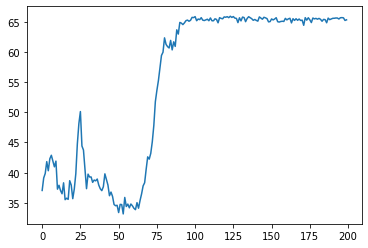

In [45]:
print(len(text_plot),len(rewards_plot))
a,b=18*128,18*128+1000
j=0
sum_len=[]
lenDist=[]
for i, t in enumerate(text_plot) :
    values=t.split()
#     print(i+1,len(values))
    sum_len.append(len(values))
    if (i+1)%128==0:
        p=sum(sum_len)/len(sum_len)
#         print(j,'*'*10,p)
        j+=1
        sum_len=[]
        lenDist.append(p)
x=[i for i in range(len(lenDist))]
plt.plot(x, lenDist)  

In [12]:
text='0 1 2 30 0 !'
text.split('!')[0]

'0 1 2 30 0 '

In [5]:
ppo_trainer = PPOTrainer(gpt2_model, gpt2_model_ref, **config)
fbs = config['forward_batch_size']
rewards_plot=[]
text_plot=[]
for epoch in tqdm(range(int(np.ceil(config["steps"]/config['batch_size'])))):
    torch.cuda.empty_cache()
    logs = dict()
    game_data = dict()
    timing = dict()
    t0 = time.time()
    
    #### get a batch from the dataset
    df_batch = df.sample(config['batch_size'])
    game_data['query'] = df_batch['query'].tolist()
    query_tensors = torch.stack(df_batch['tokens'].tolist())
    
    #### get response from gpt2
    t = time.time()
    total_length = config['txt_in_len']+config['txt_out_len']
    response_tensors = []
    for i in range(int(config['batch_size']/fbs)):
        response  = respond_to_batch(gpt2_model, query_tensors[i*fbs:(i+1)*fbs],nolegal_index,
                                     txt_len=config['txt_out_len'])
        response_tensors.append(response)
    response_tensors = torch.cat(response_tensors)
    game_data['response'] = [gpt2_tokenizer.decode(response_tensors[i, :]).split('!')[0] for i in range(config['batch_size'])]
    timing['time/get_response'] = time.time()-t
    
    #### tokenize text for sentiment analysis
    t = time.time()
    texts = [q + r for q,r in zip(game_data['query'], game_data['response'])]
    text_plot+=texts
    #统计legal illegal数量
#     islegal_tests=[t[:  t.rindex('0')+1] for t in texts]
#     print(islegal_tests)
#     print(texts)
    legalCount,illegalCount=count_is_legal(texts)
    logs['count/legalCount']=legalCount
    logs['count/illegalCount']=illegalCount
    
    sentiment_inputs, attention_masks,indices = data_prepare(texts, gpt2_tokenizer, config['max_length'])  
    sentiment_inputs=sentiment_inputs.to(device)
    attention_masks=attention_masks.to(device)
    indices=indices.to(device)
    timing['time/build_input_sentiment'] = time.time()-t

    #### get sentiment score
    t = time.time()
    rewards = []
    for i in range(int(config['batch_size']/fbs)):
        res = sentiment_model.forward(sentiment_inputs[i*fbs:(i+1)*fbs],
                                      attention_masks[i*fbs:(i+1)*fbs],
                                     indices[i*fbs:(i+1)*fbs])[:, 1].detach()
        rewards.append(res)
    rewards = torch.cat(rewards)
    timing['time/get_sentiment_preds'] = time.time()-t
    rewards_plot.append(rewards.cpu().tolist())
    #数据均衡处理
    rewards_index = sorted(range(len(rewards)), key=lambda k: rewards[k],reverse=False)  # 升序排序 reversed=False
    posNum=sum(rewards>=0).cpu().numpy()
    dataBalance=False
    print('posNum :',posNum,len(rewards))
    if posNum*2<len(rewards):#做数据均衡处理
        dataBalance=True
        largeNegNum=posNum#采样数量
        print('largeRotioNeg :',largeNegNum)
#         smallNegNum=int(posNum*0.2)#采样数量
#         print('smallRotioNeg :',smallNegNum)
#         choiceSmall=rewards_index[:len(rewards)-posNum-posNum]
#         choiceLarge=rewards_index[-posNum-posNum:-posNum]
#         print('choiceSmall :',choiceSmall)
#         print('choiceLarge :',choiceLarge)
#         if largeNegNum>len(choiceLarge):
#             largeNegNum=len(choiceLarge)
#         if smallNegNum>len(choiceSmall):
#             smallNegNum=len(choiceSmall)
#         largeIndex = np.random.choice(choiceLarge,size=largeNegNum, replace=False)
#         largeIndex=choiceLarge
#         smallIndex = np.random.choice(choiceSmall,size=smallNegNum, replace=False)
        if posNum==0:
            posNum=5
        posIndex=rewards_index[-2*posNum-1:]
#         print('smallIndex :',smallIndex)
#         print('largeIndex :',largeIndex)
        print('posIndex :',posIndex)
#         print(type(posIndex),type(smallIndex),type(largeIndex),)
        allIndex=posIndex#+list(smallIndex)#+list(largeIndex)
    if len(allIndex)==0 or len(allIndex)==1:
        continue
    if dataBalance:
        random.shuffle(allIndex)
        print('allIndex :',allIndex)
        query_tensors=query_tensors[allIndex,:]
        response_tensors=response_tensors[allIndex,:]
        rewards=rewards[allIndex]
    print(query_tensors.shape,response_tensors.shape,rewards.shape)
   
    
    #### Run PPO training 
    t = time.time()
#     stats = ppo_trainer.step(query_selected, response_selected, rewards_selected)
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    timing['time/optimization'] = time.time()-t
     
    #### Log everything
    timing['time/epoch'] = time.time()-t0
    table_rows = [list(r) for r in zip(game_data['query'], game_data['response'], rewards.cpu().tolist())]
    logs.update({'game_log':wandb.Table(
        columns=['query', 'response', 'reward'],
        rows=table_rows)})
    logs.update(timing)
    logs.update(stats)
    logs['env/reward_mean'] = torch.mean(rewards).cpu().numpy()
    logs['env/reward_std'] = torch.std(rewards).cpu().numpy()
    logs['env/reward_dist'] = rewards.cpu().numpy()
    wandb.log(logs)
#     if epoch==20:
#         break

  0%|          | 0/200 [00:00<?, ?it/s]

posNum : 14 128
largeRotioNeg : 14
posIndex : [94, 31, 77, 107, 126, 19, 111, 116, 83, 114, 70, 45, 53, 60, 52, 4, 63, 101, 124, 42, 27, 5, 57, 8, 47, 40, 50, 113, 123]
allIndex : [77, 52, 19, 70, 5, 113, 111, 47, 40, 123, 124, 116, 57, 42, 114, 83, 53, 63, 94, 4, 60, 50, 8, 45, 27, 31, 107, 101, 126]
torch.Size([29, 1]) torch.Size([29, 65]) torch.Size([29])


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.17 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
  0%|          | 1/200 [00:16<55:43, 16.80s/it]

posNum : 20 128
largeRotioNeg : 20
posIndex : [33, 24, 100, 29, 43, 118, 74, 85, 86, 38, 115, 75, 127, 57, 93, 34, 122, 91, 87, 114, 15, 121, 58, 92, 67, 65, 79, 42, 31, 45, 10, 49, 64, 80, 62, 119, 108, 77, 13, 22, 72]
allIndex : [62, 10, 115, 64, 57, 72, 85, 122, 100, 22, 86, 80, 127, 75, 79, 15, 31, 92, 49, 108, 121, 91, 77, 118, 87, 38, 43, 65, 33, 114, 119, 67, 74, 58, 93, 45, 24, 42, 34, 13, 29]
torch.Size([41, 1]) torch.Size([41, 65]) torch.Size([41])


  1%|          | 2/200 [00:33<55:10, 16.72s/it]

posNum : 12 128
largeRotioNeg : 12
posIndex : [120, 117, 126, 115, 10, 109, 92, 43, 121, 15, 111, 107, 112, 86, 95, 60, 99, 18, 19, 45, 106, 3, 90, 122, 7]
allIndex : [122, 43, 86, 3, 7, 18, 19, 92, 111, 106, 15, 99, 45, 109, 120, 90, 112, 107, 121, 10, 117, 126, 115, 60, 95]
torch.Size([25, 1]) torch.Size([25, 65]) torch.Size([25])


  2%|▏         | 3/200 [00:46<51:26, 15.67s/it]

posNum : 15 128
largeRotioNeg : 15
posIndex : [70, 32, 51, 61, 83, 0, 9, 82, 56, 28, 27, 72, 107, 118, 85, 124, 84, 86, 34, 15, 10, 31, 111, 8, 3, 92, 1, 109, 79, 37, 35]
allIndex : [92, 84, 10, 56, 28, 85, 109, 15, 83, 72, 9, 1, 86, 37, 82, 51, 111, 107, 61, 32, 79, 118, 27, 8, 0, 34, 70, 35, 124, 31, 3]
torch.Size([31, 1]) torch.Size([31, 65]) torch.Size([31])


  2%|▏         | 4/200 [01:00<49:47, 15.24s/it]

posNum : 5 128
largeRotioNeg : 5
posIndex : [9, 114, 2, 63, 118, 17, 66, 21, 73, 20, 94]
allIndex : [2, 66, 21, 73, 20, 17, 94, 114, 118, 63, 9]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


  2%|▎         | 5/200 [01:11<44:46, 13.78s/it]

posNum : 13 128
largeRotioNeg : 13
posIndex : [43, 92, 16, 84, 76, 111, 110, 42, 73, 85, 66, 41, 93, 17, 60, 108, 58, 104, 88, 122, 1, 48, 102, 99, 24, 51, 89]
allIndex : [85, 110, 42, 73, 60, 17, 111, 89, 1, 108, 92, 24, 66, 58, 104, 76, 43, 122, 16, 102, 41, 99, 93, 88, 48, 51, 84]
torch.Size([27, 1]) torch.Size([27, 65]) torch.Size([27])


  3%|▎         | 6/200 [01:24<44:10, 13.66s/it]

posNum : 7 128
largeRotioNeg : 7
posIndex : [79, 20, 74, 66, 113, 8, 75, 54, 101, 84, 69, 106, 59, 53, 62]
allIndex : [79, 101, 54, 69, 75, 59, 66, 53, 8, 84, 106, 113, 74, 62, 20]
torch.Size([15, 1]) torch.Size([15, 65]) torch.Size([15])


  4%|▎         | 7/200 [01:35<41:32, 12.92s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [46, 30, 17, 33, 112, 122, 74]
allIndex : [112, 122, 46, 30, 17, 74, 33]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


  4%|▍         | 8/200 [01:45<38:10, 11.93s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [99, 94, 54, 41, 98, 25, 90]
allIndex : [90, 94, 98, 99, 25, 41, 54]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


  4%|▍         | 9/200 [01:54<35:47, 11.24s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [10, 20, 68, 19, 87, 16, 30]
allIndex : [10, 68, 19, 87, 20, 30, 16]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


  5%|▌         | 10/200 [02:04<34:00, 10.74s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [119, 37, 19, 116, 50]
allIndex : [50, 116, 119, 37, 19]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


  6%|▌         | 11/200 [02:13<32:17, 10.25s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [7, 84, 37, 19, 93, 12, 79, 11, 51, 58, 69]
allIndex : [11, 79, 93, 37, 51, 58, 7, 12, 84, 69, 19]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


  6%|▌         | 12/200 [02:23<32:11, 10.27s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [37, 79, 27, 125, 112, 122, 109]
allIndex : [125, 37, 79, 109, 112, 122, 27]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


  6%|▋         | 13/200 [02:33<31:20, 10.06s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [39, 126, 46, 98, 44, 96, 13, 1, 49]
allIndex : [44, 49, 98, 39, 13, 46, 1, 126, 96]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


  7%|▋         | 14/200 [02:43<31:06, 10.03s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [39, 44, 119, 75, 93]
allIndex : [93, 75, 44, 119, 39]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


  8%|▊         | 15/200 [02:52<30:11,  9.79s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [35, 69, 83, 76, 19, 20, 116, 57, 49]
allIndex : [19, 57, 116, 83, 76, 69, 49, 35, 20]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


  8%|▊         | 16/200 [03:02<30:10,  9.84s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [46, 108, 116, 101, 36]
allIndex : [46, 116, 36, 101, 108]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


  8%|▊         | 17/200 [03:11<29:29,  9.67s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [93, 113, 71]
allIndex : [93, 71, 113]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


  9%|▉         | 18/200 [03:20<28:37,  9.44s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [115, 54, 118, 83, 97, 55, 31, 87, 73]
allIndex : [118, 54, 73, 87, 31, 55, 115, 97, 83]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


 10%|▉         | 19/200 [03:30<29:02,  9.63s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [105, 97, 51, 54, 120, 124, 106]
allIndex : [97, 54, 120, 124, 106, 105, 51]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 10%|█         | 20/200 [03:40<28:48,  9.60s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [120, 81, 18, 63, 49, 109, 82, 10, 56, 16, 22]
allIndex : [49, 56, 63, 16, 81, 22, 18, 109, 10, 120, 82]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 10%|█         | 21/200 [03:50<29:18,  9.82s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [86, 93, 11, 39, 101, 33, 15, 0, 59, 25, 113]
allIndex : [101, 59, 86, 113, 39, 15, 25, 33, 0, 11, 93]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 11%|█         | 22/200 [04:01<29:36,  9.98s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [60, 57, 17, 123, 102, 31, 67, 79, 68]
allIndex : [102, 57, 60, 123, 17, 79, 67, 68, 31]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


 12%|█▏        | 23/200 [04:11<29:25,  9.98s/it]

posNum : 8 128
largeRotioNeg : 8
posIndex : [35, 19, 109, 23, 119, 111, 29, 98, 28, 100, 37, 88, 63, 49, 44, 13, 64]
allIndex : [100, 64, 109, 29, 37, 49, 23, 44, 13, 98, 35, 19, 119, 63, 28, 111, 88]
torch.Size([17, 1]) torch.Size([17, 65]) torch.Size([17])


 12%|█▏        | 24/200 [04:22<30:38, 10.44s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [50, 103, 33, 77, 44]
allIndex : [77, 33, 44, 50, 103]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 12%|█▎        | 25/200 [04:31<29:23, 10.08s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [32, 44, 63]
allIndex : [32, 63, 44]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 13%|█▎        | 26/200 [04:40<28:08,  9.70s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [63, 112, 30]
allIndex : [112, 30, 63]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 14%|█▎        | 27/200 [04:49<27:11,  9.43s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [97, 3, 54]
allIndex : [54, 97, 3]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 14%|█▍        | 28/200 [04:58<26:34,  9.27s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [12, 121, 62]
allIndex : [121, 62, 12]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 14%|█▍        | 29/200 [05:07<26:02,  9.14s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [97, 126, 23]
allIndex : [97, 126, 23]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 15%|█▌        | 30/200 [05:16<25:42,  9.08s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [121, 110, 41]
allIndex : [41, 110, 121]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 16%|█▌        | 31/200 [05:25<25:23,  9.02s/it]

posNum : 6 128
largeRotioNeg : 6
posIndex : [3, 12, 104, 71, 107, 100, 120, 118, 47, 37, 126, 90, 70]
allIndex : [126, 118, 100, 104, 90, 70, 12, 107, 120, 3, 71, 37, 47]
torch.Size([13, 1]) torch.Size([13, 65]) torch.Size([13])


 16%|█▌        | 32/200 [05:35<26:49,  9.58s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [74, 45, 3]
allIndex : [45, 74, 3]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 16%|█▋        | 33/200 [05:44<26:04,  9.37s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [127, 19, 6, 12, 65, 57, 55, 25, 47]
allIndex : [12, 6, 65, 25, 55, 19, 47, 127, 57]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


 17%|█▋        | 34/200 [05:54<26:21,  9.53s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [98, 17, 79, 66, 40, 45, 126]
allIndex : [40, 98, 79, 66, 126, 45, 17]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 18%|█▊        | 35/200 [06:04<26:13,  9.54s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [90, 44, 65, 99, 1, 52, 29, 37, 3]
allIndex : [99, 52, 37, 3, 44, 90, 65, 29, 1]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


 18%|█▊        | 36/200 [06:14<26:24,  9.66s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [108, 36, 50]
allIndex : [36, 50, 108]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 18%|█▊        | 37/200 [06:23<25:39,  9.45s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [63, 121, 5, 111, 8, 103, 7]
allIndex : [7, 103, 121, 5, 63, 8, 111]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 19%|█▉        | 38/200 [06:32<25:39,  9.50s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [12, 110, 117]
allIndex : [12, 110, 117]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 20%|█▉        | 39/200 [06:41<25:00,  9.32s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [109, 89, 2]
allIndex : [2, 109, 89]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 20%|██        | 40/200 [06:50<24:30,  9.19s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [70, 4, 13]
allIndex : [13, 4, 70]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 20%|██        | 41/200 [06:59<24:09,  9.11s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [53, 36, 24, 110, 59]
allIndex : [110, 59, 36, 24, 53]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 21%|██        | 42/200 [07:08<24:07,  9.16s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [94, 109, 107]
allIndex : [109, 107, 94]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 22%|██▏       | 43/200 [07:17<23:45,  9.08s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [124, 119, 100, 97, 24]
allIndex : [124, 100, 24, 119, 97]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 22%|██▏       | 44/200 [07:26<23:44,  9.13s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [19, 35, 81, 48, 78, 85, 117]
allIndex : [19, 35, 48, 81, 117, 85, 78]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 22%|██▎       | 45/200 [07:36<23:59,  9.28s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [12, 95, 101]
allIndex : [12, 95, 101]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 23%|██▎       | 46/200 [07:45<23:31,  9.16s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [25, 79, 93, 78, 114, 8, 95]
allIndex : [78, 114, 95, 8, 79, 93, 25]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 24%|██▎       | 47/200 [07:55<23:44,  9.31s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [50, 76, 49]
allIndex : [49, 76, 50]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 24%|██▍       | 48/200 [08:04<23:19,  9.21s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [85, 95, 115, 68, 92]
allIndex : [68, 95, 92, 115, 85]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 24%|██▍       | 49/200 [08:13<23:14,  9.24s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [47, 21, 98, 33, 113, 73, 91, 57, 31, 58, 53]
allIndex : [113, 58, 73, 57, 33, 31, 47, 21, 98, 53, 91]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 25%|██▌       | 50/200 [08:23<23:58,  9.59s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [8, 34, 124]
allIndex : [124, 34, 8]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 26%|██▌       | 51/200 [08:32<23:21,  9.41s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [101, 126, 55]
allIndex : [55, 126, 101]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 26%|██▌       | 52/200 [08:41<22:54,  9.28s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [105, 70, 124, 41, 82, 99, 30, 60, 0, 16, 109]
allIndex : [60, 30, 99, 41, 109, 16, 124, 82, 105, 0, 70]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 26%|██▋       | 53/200 [08:52<23:45,  9.70s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [88, 35, 19]
allIndex : [35, 88, 19]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 27%|██▋       | 54/200 [09:01<23:04,  9.48s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [97, 33, 51, 92, 119]
allIndex : [33, 119, 97, 92, 51]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 28%|██▊       | 55/200 [09:10<22:46,  9.42s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [16, 28, 119]
allIndex : [16, 28, 119]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 28%|██▊       | 56/200 [09:19<22:16,  9.28s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [118, 98, 6]
allIndex : [118, 6, 98]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 28%|██▊       | 57/200 [09:28<21:50,  9.17s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [56, 46, 39, 64, 79, 89, 92, 94, 45, 127, 82]
allIndex : [39, 56, 46, 89, 79, 64, 45, 82, 94, 92, 127]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 29%|██▉       | 58/200 [09:38<22:34,  9.54s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [114, 47, 32, 90, 55]
allIndex : [114, 90, 32, 47, 55]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 30%|██▉       | 59/200 [09:48<22:10,  9.44s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [89, 0, 114, 41, 70, 126, 36, 79, 86, 26, 98]
allIndex : [36, 86, 0, 79, 98, 26, 114, 126, 41, 89, 70]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 30%|███       | 60/200 [09:58<22:45,  9.76s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [79, 56, 75, 115, 105]
allIndex : [79, 105, 56, 75, 115]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 30%|███       | 61/200 [10:07<22:15,  9.61s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [92, 47, 69, 41, 93, 38, 54, 1, 8, 10, 50]
allIndex : [69, 8, 10, 93, 47, 1, 38, 50, 41, 92, 54]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 31%|███       | 62/200 [10:18<22:41,  9.87s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [41, 25, 26]
allIndex : [26, 25, 41]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 32%|███▏      | 63/200 [10:27<21:48,  9.55s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [125, 40, 27]
allIndex : [40, 125, 27]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 32%|███▏      | 64/200 [10:36<21:08,  9.33s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [102, 24, 111, 27, 91]
allIndex : [111, 24, 102, 91, 27]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 32%|███▎      | 65/200 [10:45<20:57,  9.31s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [102, 115, 16]
allIndex : [16, 102, 115]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 33%|███▎      | 66/200 [10:54<20:29,  9.18s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [6, 12, 69]
allIndex : [6, 69, 12]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 34%|███▎      | 67/200 [11:03<20:09,  9.09s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [43, 86, 123, 111, 103, 30, 91, 125, 89, 76, 9]
allIndex : [111, 103, 123, 91, 43, 9, 30, 89, 86, 76, 125]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 34%|███▍      | 68/200 [11:13<20:53,  9.50s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [42, 98, 109, 58, 7, 85, 96, 123, 14, 104, 107]
allIndex : [7, 14, 42, 107, 109, 96, 85, 104, 123, 58, 98]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 34%|███▍      | 69/200 [11:23<21:20,  9.78s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [69, 19, 83]
allIndex : [69, 83, 19]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 35%|███▌      | 70/200 [11:32<20:36,  9.51s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [15, 29, 54]
allIndex : [54, 15, 29]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 36%|███▌      | 71/200 [11:41<19:56,  9.27s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [72, 24, 127]
allIndex : [72, 24, 127]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 36%|███▌      | 72/200 [11:50<19:29,  9.13s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [85, 29, 67]
allIndex : [85, 29, 67]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 36%|███▋      | 73/200 [11:59<19:09,  9.05s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [55, 5, 39]
allIndex : [55, 39, 5]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 37%|███▋      | 74/200 [12:08<18:56,  9.02s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [60, 71, 57]
allIndex : [60, 57, 71]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 38%|███▊      | 75/200 [12:16<18:39,  8.95s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [1, 62, 71, 52, 97, 34, 107, 90, 6, 101, 21]
allIndex : [107, 6, 21, 71, 90, 52, 34, 97, 1, 62, 101]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 38%|███▊      | 76/200 [12:27<19:25,  9.40s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [15, 2, 33, 4, 23]
allIndex : [23, 15, 33, 2, 4]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 38%|███▊      | 77/200 [12:36<19:07,  9.33s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [108, 107, 118, 17, 64, 27, 103, 13, 44, 53, 14]
allIndex : [107, 17, 64, 108, 14, 13, 44, 103, 27, 53, 118]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 39%|███▉      | 78/200 [12:46<19:38,  9.66s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [85, 49, 4, 56, 121, 13, 22, 83, 41, 58, 45]
allIndex : [4, 45, 58, 13, 22, 85, 56, 41, 49, 121, 83]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 40%|███▉      | 79/200 [12:57<20:00,  9.92s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [98, 70, 69]
allIndex : [69, 70, 98]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 40%|████      | 80/200 [13:06<19:15,  9.63s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [66, 121, 82]
allIndex : [121, 82, 66]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 40%|████      | 81/200 [13:15<18:38,  9.40s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [26, 6, 76, 49, 20]
allIndex : [76, 6, 26, 20, 49]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 41%|████      | 82/200 [13:24<18:21,  9.34s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [24, 33, 5]
allIndex : [5, 24, 33]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 42%|████▏     | 83/200 [13:33<17:53,  9.18s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [7, 75, 65]
allIndex : [7, 65, 75]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 42%|████▏     | 84/200 [13:42<17:34,  9.09s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [118, 91, 58, 32, 46, 61, 10, 92, 2, 125, 64]
allIndex : [58, 125, 61, 10, 118, 92, 46, 32, 64, 91, 2]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 42%|████▎     | 85/200 [13:52<18:11,  9.49s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [105, 104, 53]
allIndex : [104, 105, 53]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 43%|████▎     | 86/200 [14:01<17:39,  9.29s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [27, 90, 64]
allIndex : [27, 90, 64]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 44%|████▎     | 87/200 [14:10<17:17,  9.18s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [11, 124, 13, 26, 12, 34, 30]
allIndex : [124, 30, 13, 12, 34, 26, 11]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 44%|████▍     | 88/200 [14:19<17:20,  9.29s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [94, 61, 15, 101, 78, 77, 17, 35, 75, 123, 21]
allIndex : [15, 21, 78, 35, 101, 123, 94, 77, 61, 75, 17]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 44%|████▍     | 89/200 [14:30<17:46,  9.61s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [88, 102, 42, 40, 7, 23, 125, 116, 20, 101, 59]
allIndex : [40, 42, 7, 116, 23, 88, 125, 101, 20, 102, 59]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 45%|████▌     | 90/200 [14:40<18:05,  9.87s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [116, 53, 30, 61, 117, 32, 87, 67, 37, 28, 38]
allIndex : [53, 87, 116, 28, 61, 30, 38, 67, 117, 37, 32]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 46%|████▌     | 91/200 [14:51<18:16, 10.06s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [104, 83, 16, 37, 89, 76, 33, 12, 26, 7, 22]
allIndex : [12, 26, 83, 89, 104, 37, 76, 16, 7, 22, 33]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 46%|████▌     | 92/200 [15:01<18:20, 10.19s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [63, 107, 38, 5, 45, 96, 17, 93, 88, 86, 39]
allIndex : [107, 5, 86, 39, 88, 17, 93, 45, 38, 96, 63]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 46%|████▋     | 93/200 [15:12<18:20, 10.28s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [5, 57, 22]
allIndex : [22, 5, 57]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 47%|████▋     | 94/200 [15:21<17:27,  9.88s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [72, 111, 104, 51, 13, 58, 41]
allIndex : [13, 58, 111, 72, 51, 41, 104]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 48%|████▊     | 95/200 [15:30<17:12,  9.84s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [88, 80, 78, 50, 57, 92, 125, 7, 89, 23, 97]
allIndex : [125, 80, 92, 7, 23, 97, 88, 78, 89, 50, 57]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 48%|████▊     | 96/200 [15:41<17:20, 10.01s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [15, 55, 4, 114, 81, 22, 125, 49, 43, 104, 92]
allIndex : [114, 55, 49, 4, 15, 92, 43, 81, 104, 22, 125]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 48%|████▊     | 97/200 [15:51<17:23, 10.13s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [39, 76, 110]
allIndex : [110, 39, 76]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 49%|████▉     | 98/200 [16:00<16:32,  9.73s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [61, 27, 21]
allIndex : [61, 27, 21]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 50%|████▉     | 99/200 [16:09<15:56,  9.47s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [17, 110, 86]
allIndex : [86, 17, 110]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 50%|█████     | 100/200 [16:18<15:30,  9.31s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [90, 21, 23]
allIndex : [90, 23, 21]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 50%|█████     | 101/200 [16:27<15:08,  9.17s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [100, 88, 3, 74, 24, 73, 59, 32, 91, 55, 13]
allIndex : [13, 32, 100, 3, 73, 59, 88, 24, 74, 55, 91]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 51%|█████     | 102/200 [16:37<15:35,  9.55s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [85, 17, 126, 90, 86]
allIndex : [17, 126, 86, 90, 85]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 52%|█████▏    | 103/200 [16:46<15:15,  9.44s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [28, 20, 68]
allIndex : [28, 68, 20]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 52%|█████▏    | 104/200 [16:55<14:50,  9.27s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [96, 63, 126]
allIndex : [63, 96, 126]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 52%|█████▎    | 105/200 [17:04<14:34,  9.20s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [27, 89, 125, 124, 3, 38, 118, 127, 26, 97, 95]
allIndex : [125, 97, 89, 26, 38, 3, 95, 27, 118, 124, 127]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 53%|█████▎    | 106/200 [17:15<15:01,  9.59s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [115, 71, 103, 85, 102, 40, 50]
allIndex : [50, 85, 102, 40, 71, 103, 115]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 54%|█████▎    | 107/200 [17:24<14:56,  9.64s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [39, 40, 15, 64, 107, 116, 34, 73, 42, 126, 61]
allIndex : [15, 107, 39, 40, 126, 61, 42, 64, 116, 34, 73]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 54%|█████▍    | 108/200 [17:35<15:12,  9.92s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [66, 68, 114]
allIndex : [66, 114, 68]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 55%|█████▍    | 109/200 [17:44<14:36,  9.63s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [13, 31, 93, 79, 71, 4, 75, 102, 65, 123, 89]
allIndex : [75, 123, 93, 65, 71, 102, 4, 31, 79, 89, 13]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 55%|█████▌    | 110/200 [17:55<14:50,  9.89s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [45, 73, 87]
allIndex : [73, 87, 45]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 56%|█████▌    | 111/200 [18:03<14:16,  9.62s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [10, 34, 76]
allIndex : [10, 76, 34]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 56%|█████▌    | 112/200 [18:12<13:49,  9.43s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [24, 87, 19, 20, 57, 95, 112, 109, 51, 76, 104]
allIndex : [19, 51, 20, 24, 87, 95, 57, 112, 109, 104, 76]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 56%|█████▋    | 113/200 [18:23<14:05,  9.71s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [92, 47, 54]
allIndex : [54, 47, 92]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 57%|█████▋    | 114/200 [18:32<13:33,  9.46s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [106, 96, 110, 71, 109, 99, 68, 53, 5, 50, 100]
allIndex : [71, 99, 5, 68, 96, 110, 53, 50, 106, 100, 109]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 57%|█████▊    | 115/200 [18:42<13:47,  9.74s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [84, 28, 51, 44, 54, 27, 118, 30, 72, 103, 89]
allIndex : [54, 103, 44, 51, 84, 28, 72, 118, 30, 89, 27]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 58%|█████▊    | 116/200 [18:53<13:54,  9.94s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [52, 120, 34]
allIndex : [52, 34, 120]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 58%|█████▊    | 117/200 [19:01<13:20,  9.64s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [72, 20, 43, 55, 41, 52, 75, 13, 25, 38, 37]
allIndex : [55, 38, 72, 25, 43, 75, 52, 37, 41, 20, 13]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 59%|█████▉    | 118/200 [19:12<13:28,  9.86s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [88, 57, 104]
allIndex : [57, 104, 88]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 60%|█████▉    | 119/200 [19:21<12:55,  9.57s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [3, 48, 36, 103, 9, 71, 60, 56, 53, 50, 85]
allIndex : [3, 48, 85, 56, 9, 53, 50, 36, 103, 60, 71]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 60%|██████    | 120/200 [19:31<13:05,  9.82s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [70, 59, 78, 121, 95, 30, 4, 122, 40, 90, 29]
allIndex : [122, 121, 29, 78, 70, 95, 90, 4, 59, 40, 30]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 60%|██████    | 121/200 [19:42<13:10, 10.00s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [113, 3, 67, 51, 81, 101, 123, 77, 95, 43, 39]
allIndex : [43, 123, 39, 113, 51, 77, 101, 67, 81, 3, 95]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 61%|██████    | 122/200 [19:52<13:10, 10.14s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [46, 86, 28, 13, 9, 22, 53]
allIndex : [9, 86, 13, 28, 46, 53, 22]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 62%|██████▏   | 123/200 [20:02<12:51, 10.02s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [120, 119, 81, 16, 113, 60, 98, 125, 102, 34, 1]
allIndex : [16, 113, 102, 98, 119, 81, 120, 125, 60, 34, 1]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 62%|██████▏   | 124/200 [20:12<12:48, 10.11s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [61, 113, 53, 77, 111, 48, 66, 116, 54, 23, 97]
allIndex : [23, 113, 97, 53, 66, 116, 54, 77, 111, 48, 61]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 62%|██████▎   | 125/200 [20:23<12:47, 10.24s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [126, 73, 90, 9, 39, 124, 53, 41, 64, 34, 84]
allIndex : [84, 124, 73, 41, 64, 53, 39, 34, 90, 9, 126]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 63%|██████▎   | 126/200 [20:33<12:40, 10.27s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [85, 97, 17, 103, 23, 88, 113, 15, 55, 115, 49]
allIndex : [55, 88, 113, 103, 49, 85, 15, 115, 23, 17, 97]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 64%|██████▎   | 127/200 [20:43<12:32, 10.31s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [88, 17, 102, 62, 72, 4, 101, 126, 54, 98, 70]
allIndex : [54, 4, 126, 72, 62, 70, 88, 101, 102, 17, 98]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 64%|██████▍   | 128/200 [20:54<12:22, 10.32s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [5, 120, 112, 123, 28, 93, 49, 77, 16, 125, 102]
allIndex : [120, 125, 93, 16, 102, 112, 28, 49, 77, 123, 5]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 64%|██████▍   | 129/200 [21:04<12:14, 10.35s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [94, 119, 24]
allIndex : [94, 119, 24]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 65%|██████▌   | 130/200 [21:13<11:33,  9.91s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [127, 56, 78]
allIndex : [56, 127, 78]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 66%|██████▌   | 131/200 [21:22<11:02,  9.60s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [87, 122, 91, 4, 36, 94, 121, 17, 59, 113, 118]
allIndex : [91, 121, 122, 36, 59, 118, 4, 87, 113, 17, 94]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 66%|██████▌   | 132/200 [21:32<11:09,  9.84s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [14, 44, 18, 29, 57, 26, 109, 99, 58, 24, 91]
allIndex : [91, 99, 14, 58, 44, 26, 24, 57, 109, 29, 18]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 66%|██████▋   | 133/200 [21:43<11:12, 10.04s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [72, 33, 75, 14, 59, 111, 5, 63, 47, 37, 108]
allIndex : [47, 72, 5, 33, 75, 108, 14, 37, 111, 59, 63]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 67%|██████▋   | 134/200 [21:53<11:11, 10.17s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [105, 14, 42, 97, 90, 21, 115, 61, 104, 29, 19]
allIndex : [14, 19, 29, 42, 104, 61, 21, 90, 105, 97, 115]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 68%|██████▊   | 135/200 [22:04<11:06, 10.25s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [42, 95, 124]
allIndex : [124, 95, 42]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 68%|██████▊   | 136/200 [22:13<10:29,  9.83s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [25, 107, 18, 16, 123, 74, 77, 63, 114, 90, 104]
allIndex : [25, 18, 90, 77, 123, 114, 107, 74, 104, 16, 63]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 68%|██████▊   | 137/200 [22:23<10:32, 10.05s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [76, 22, 6]
allIndex : [22, 6, 76]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 69%|██████▉   | 138/200 [22:32<10:02,  9.71s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [77, 6, 115]
allIndex : [77, 6, 115]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 70%|██████▉   | 139/200 [22:41<09:38,  9.48s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [88, 3, 116, 108, 96, 42, 0, 58, 24, 21, 113]
allIndex : [24, 42, 116, 113, 0, 58, 21, 88, 108, 3, 96]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 70%|███████   | 140/200 [22:51<09:45,  9.75s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [3, 25, 94]
allIndex : [25, 3, 94]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 70%|███████   | 141/200 [23:00<09:20,  9.51s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [63, 21, 24, 41, 118, 107, 78, 101, 71, 95, 1]
allIndex : [95, 78, 41, 107, 24, 101, 1, 118, 21, 63, 71]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 71%|███████   | 142/200 [23:11<09:27,  9.78s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [74, 124, 89, 47, 121, 27, 44, 80, 114, 21, 51]
allIndex : [51, 80, 114, 44, 121, 27, 47, 124, 89, 74, 21]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 72%|███████▏  | 143/200 [23:21<09:28,  9.97s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [112, 66, 105, 40, 99, 90, 31, 87, 70, 58, 38]
allIndex : [66, 70, 112, 105, 90, 99, 58, 38, 31, 87, 40]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 72%|███████▏  | 144/200 [23:32<09:27, 10.13s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [13, 80, 59]
allIndex : [80, 13, 59]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 72%|███████▎  | 145/200 [23:41<08:56,  9.76s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [31, 9, 63, 72, 103, 101, 92, 83, 86, 117, 104]
allIndex : [86, 104, 83, 9, 31, 101, 72, 103, 92, 63, 117]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 73%|███████▎  | 146/200 [23:51<08:58,  9.97s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [86, 99, 59, 117, 103, 3, 62, 29, 26, 74, 77]
allIndex : [29, 86, 103, 59, 3, 117, 74, 99, 77, 26, 62]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 74%|███████▎  | 147/200 [24:01<08:54, 10.09s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [89, 122, 60, 108, 87, 6, 79]
allIndex : [87, 6, 89, 60, 79, 108, 122]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 74%|███████▍  | 148/200 [24:11<08:38,  9.97s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [78, 94, 43, 97, 0, 75, 77, 92, 58, 20, 57]
allIndex : [94, 97, 57, 92, 0, 77, 20, 78, 43, 58, 75]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 74%|███████▍  | 149/200 [24:22<08:37, 10.14s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [22, 38, 82, 40, 93, 49, 2, 61, 6, 74, 14]
allIndex : [49, 22, 40, 74, 38, 6, 82, 61, 14, 93, 2]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 75%|███████▌  | 150/200 [24:32<08:27, 10.15s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [125, 54, 12, 63, 102, 101, 35, 32, 79, 123, 5]
allIndex : [63, 125, 102, 54, 123, 101, 12, 79, 5, 32, 35]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 76%|███████▌  | 151/200 [24:42<08:21, 10.24s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [33, 121, 10, 27, 39, 60, 17]
allIndex : [17, 27, 60, 33, 10, 121, 39]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 76%|███████▌  | 152/200 [24:52<08:01, 10.04s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [99, 53, 115]
allIndex : [53, 99, 115]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 76%|███████▋  | 153/200 [25:01<07:35,  9.70s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [34, 14, 49]
allIndex : [34, 49, 14]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 77%|███████▋  | 154/200 [25:10<07:15,  9.46s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [1, 80, 32]
allIndex : [1, 32, 80]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 78%|███████▊  | 155/200 [25:19<06:58,  9.30s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [47, 77, 3, 80, 48, 60, 42, 78, 101, 45, 41]
allIndex : [41, 45, 80, 101, 48, 77, 3, 42, 78, 60, 47]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 78%|███████▊  | 156/200 [25:29<07:05,  9.66s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [16, 89, 109, 3, 52]
allIndex : [89, 3, 52, 16, 109]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 78%|███████▊  | 157/200 [25:38<06:52,  9.60s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [8, 34, 84, 38, 70, 107, 5, 28, 96, 69, 92]
allIndex : [107, 28, 92, 69, 34, 38, 5, 8, 84, 96, 70]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 79%|███████▉  | 158/200 [25:49<06:54,  9.86s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [2, 7, 4, 119, 13, 97, 98, 60, 35, 82, 90]
allIndex : [7, 2, 4, 98, 82, 35, 119, 90, 60, 13, 97]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 80%|███████▉  | 159/200 [25:59<06:51, 10.03s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [119, 1, 22, 21, 35]
allIndex : [35, 119, 1, 21, 22]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 80%|████████  | 160/200 [26:09<06:33,  9.83s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [38, 14, 0, 82, 56]
allIndex : [0, 38, 14, 56, 82]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 80%|████████  | 161/200 [26:18<06:17,  9.67s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [0, 35, 36]
allIndex : [36, 35, 0]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 81%|████████  | 162/200 [26:27<05:59,  9.46s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [34, 76, 41]
allIndex : [41, 34, 76]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 82%|████████▏ | 163/200 [26:36<05:45,  9.34s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [69, 8, 112, 22, 73]
allIndex : [22, 8, 73, 69, 112]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 82%|████████▏ | 164/200 [26:45<05:36,  9.35s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [73, 84, 89, 88, 44]
allIndex : [89, 84, 88, 44, 73]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 82%|████████▎ | 165/200 [26:55<05:27,  9.35s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [112, 28, 61]
allIndex : [28, 112, 61]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 83%|████████▎ | 166/200 [27:04<05:14,  9.25s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [104, 51, 117, 23, 34]
allIndex : [23, 51, 117, 34, 104]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 84%|████████▎ | 167/200 [27:13<05:05,  9.26s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [117, 47, 54, 31, 17, 89, 49, 34, 119, 101, 120]
allIndex : [120, 49, 101, 34, 89, 54, 117, 17, 31, 47, 119]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 84%|████████▍ | 168/200 [27:24<05:08,  9.64s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [121, 21, 46, 16, 125, 31, 81, 40, 12, 32, 91]
allIndex : [32, 16, 125, 40, 91, 121, 12, 46, 81, 31, 21]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 84%|████████▍ | 169/200 [27:34<05:07,  9.92s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [78, 37, 35]
allIndex : [35, 37, 78]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 85%|████████▌ | 170/200 [27:43<04:48,  9.63s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [58, 104, 27]
allIndex : [104, 27, 58]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 86%|████████▌ | 171/200 [27:52<04:33,  9.43s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [83, 72, 62, 43, 93, 98, 37, 28, 29, 61, 116]
allIndex : [28, 83, 62, 43, 98, 116, 61, 72, 37, 29, 93]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 86%|████████▌ | 172/200 [28:03<04:32,  9.74s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [7, 11, 89]
allIndex : [7, 89, 11]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 86%|████████▋ | 173/200 [28:12<04:16,  9.51s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [2, 52, 47]
allIndex : [52, 47, 2]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 87%|████████▋ | 174/200 [28:20<04:01,  9.30s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [9, 108, 41, 71, 18]
allIndex : [9, 41, 71, 18, 108]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 88%|████████▊ | 175/200 [28:30<03:52,  9.30s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [52, 10, 12, 41, 85, 2, 56, 35, 1, 77, 103]
allIndex : [85, 41, 2, 12, 103, 10, 52, 35, 56, 1, 77]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 88%|████████▊ | 176/200 [28:40<03:51,  9.63s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [58, 81, 31]
allIndex : [81, 58, 31]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 88%|████████▊ | 177/200 [28:49<03:37,  9.44s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [23, 16, 98]
allIndex : [98, 16, 23]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 89%|████████▉ | 178/200 [28:58<03:25,  9.32s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [25, 37, 46, 73, 67, 108, 110, 68, 7, 74, 26]
allIndex : [26, 46, 73, 68, 67, 7, 25, 110, 108, 74, 37]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 90%|████████▉ | 179/200 [29:09<03:23,  9.67s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [0, 23, 84]
allIndex : [23, 0, 84]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 90%|█████████ | 180/200 [29:17<03:08,  9.44s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [112, 29, 20, 120, 51]
allIndex : [29, 51, 112, 20, 120]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 90%|█████████ | 181/200 [29:27<02:59,  9.45s/it]

posNum : 3 128
largeRotioNeg : 3
posIndex : [41, 112, 100, 71, 78, 114, 64]
allIndex : [114, 100, 78, 112, 41, 71, 64]
torch.Size([7, 1]) torch.Size([7, 65]) torch.Size([7])


 91%|█████████ | 182/200 [29:37<02:51,  9.52s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [61, 69, 75, 97, 127, 109, 19, 56, 74, 71, 6]
allIndex : [97, 6, 69, 71, 56, 19, 127, 61, 75, 74, 109]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 92%|█████████▏| 183/200 [29:47<02:46,  9.80s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [77, 12, 84]
allIndex : [12, 84, 77]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 92%|█████████▏| 184/200 [29:56<02:32,  9.52s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [83, 71, 0, 8, 89, 62, 24, 46, 70, 118, 91]
allIndex : [0, 71, 89, 24, 62, 83, 8, 70, 118, 46, 91]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 92%|█████████▎| 185/200 [30:06<02:26,  9.79s/it]

posNum : 0 128
largeRotioNeg : 0
posIndex : [8, 57, 64, 106, 102, 54, 81, 123, 121, 61, 16]
allIndex : [81, 64, 16, 102, 61, 121, 54, 57, 106, 8, 123]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 93%|█████████▎| 186/200 [30:17<02:19,  9.97s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [48, 9, 31]
allIndex : [48, 9, 31]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 94%|█████████▎| 187/200 [30:26<02:05,  9.65s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [95, 127, 73, 8, 65]
allIndex : [73, 95, 8, 127, 65]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 94%|█████████▍| 188/200 [30:35<01:54,  9.54s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [14, 59, 126]
allIndex : [59, 14, 126]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 94%|█████████▍| 189/200 [30:44<01:42,  9.34s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [3, 79, 42, 122, 2]
allIndex : [3, 122, 42, 79, 2]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 95%|█████████▌| 190/200 [30:53<01:33,  9.32s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [111, 112, 57, 119, 55]
allIndex : [119, 111, 112, 55, 57]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 96%|█████████▌| 191/200 [31:03<01:24,  9.35s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [4, 14, 81]
allIndex : [4, 14, 81]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 96%|█████████▌| 192/200 [31:12<01:13,  9.24s/it]

posNum : 4 128
largeRotioNeg : 4
posIndex : [77, 33, 83, 58, 56, 49, 69, 114, 75]
allIndex : [49, 75, 56, 69, 114, 83, 33, 58, 77]
torch.Size([9, 1]) torch.Size([9, 65]) torch.Size([9])


 96%|█████████▋| 193/200 [31:22<01:06,  9.51s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [54, 112, 33, 114, 78]
allIndex : [114, 33, 54, 112, 78]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 97%|█████████▋| 194/200 [31:31<00:56,  9.46s/it]

posNum : 5 128
largeRotioNeg : 5
posIndex : [80, 34, 39, 71, 66, 74, 67, 93, 6, 14, 100]
allIndex : [74, 39, 93, 71, 100, 6, 67, 34, 14, 80, 66]
torch.Size([11, 1]) torch.Size([11, 65]) torch.Size([11])


 98%|█████████▊| 195/200 [31:42<00:48,  9.78s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [127, 124, 83, 71, 27]
allIndex : [71, 27, 127, 83, 124]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


 98%|█████████▊| 196/200 [31:51<00:38,  9.65s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [106, 74, 3]
allIndex : [106, 74, 3]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 98%|█████████▊| 197/200 [32:00<00:28,  9.43s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [111, 90, 22]
allIndex : [90, 22, 111]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


 99%|█████████▉| 198/200 [32:09<00:18,  9.29s/it]

posNum : 2 128
largeRotioNeg : 2
posIndex : [13, 44, 53, 89, 88]
allIndex : [88, 13, 53, 44, 89]
torch.Size([5, 1]) torch.Size([5, 65]) torch.Size([5])


100%|█████████▉| 199/200 [32:18<00:09,  9.29s/it]

posNum : 1 128
largeRotioNeg : 1
posIndex : [76, 86, 97]
allIndex : [97, 76, 86]
torch.Size([3, 1]) torch.Size([3, 65]) torch.Size([3])


100%|██████████| 200/200 [32:27<00:00,  9.74s/it]


In [13]:
for t in rewards_plot[:10]:
    print(len(t))

60
31
23
9
7
25
16
14
12
1


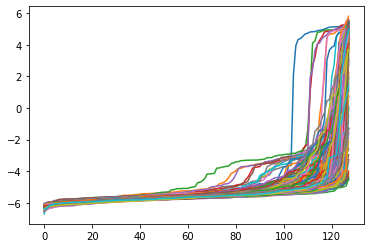

In [6]:
rewards_plot
import matplotlib.pyplot as plt
#对score进行排序 画出分布图
for scores in rewards_plot[:]:
    scores=sorted(scores)
    posNum=sum(np.array(scores)>=0)
#     print(posNum)
#     len(scores),scores[:10]
    x=[i for i in range(len(scores))]
    plt.plot(x, scores)  

In [13]:
# len(game_data['response'])
# game_data['response']
# torch.Size([128, 1]) torch.Size([128, 65]) torch.Size([128])
for i in range(0):
    print(i)

In [13]:
data=[38, 33, 125, 65, 58, 105, 19, 106, 1, 92, 111, 63, 100, 85, 71, 118, 82, 116, 119, 75, 15, 2, 54, 37, 94, 36, 9, 127, 97, 114, 47, 91, 102, 121, 55, 14, 123, 60, 78, 87, 110, 109, 53, 25, 64, 40, 5, 124, 29, 7, 45, 112, 52, 28, 62, 30, 48, 122, 57]
len(data)

59

In [27]:
torch.save(gpt2_model, '/data/hdj/data/CodeBERT/codesearch/results/gpt2_model_0207_1.pkl')
# gpt2_model = torch.load('/data/hdj/data/CodeBERT/codesearch/results/gpt2_model.pkl')

In [11]:
torch.cuda.empty_cache()
_ = gpt2_model.eval()

In [7]:
#### get a batch from the dataset
total=0
bs = 64
query_list=[]
response_before=[]
response_after=[]
rewards_before=[]
rewards_after=[]
while total>=0:
    game_data_test = dict()
    df_batch = df.sample(bs)
    game_data_test['query'] = df_batch['query'].tolist()
#     query_list+=df_batch['query'].tolist()
    query_tensors = torch.stack(df_batch['tokens'].tolist())

    #### get response from gpt2 and gpt2_ref
    total_length = config['txt_in_len']+config['txt_out_len']
    response_tensors_ref  = respond_to_batch(gpt2_model_ref, query_tensors,nolegal_index, txt_len=config['txt_out_len'])
    game_data_test['response (before)'] = [gpt2_tokenizer.decode(response_tensors_ref[i, :]) for i in range(bs)]
#     response_before+=[gpt2_tokenizer.decode(response_tensors_ref[i, :]) for i in range(bs)]
    response_tensors  = respond_to_batch(gpt2_model, query_tensors,nolegal_index, txt_len=config['txt_out_len'])
    game_data_test['response (after)'] = [gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(bs)]
#     response_after+=[gpt2_tokenizer.decode(response_tensors[i, :]) for i in range(bs)]
    #### sentiment analysis of query/response pairs before/after
    texts = [q + r for q,r in zip(game_data_test['query'], game_data_test['response (before)'])]
    sentiment_inputs, attention_masks,indices = data_prepare(texts, gpt2_tokenizer, config['max_length'])  
    sentiment_inputs=sentiment_inputs.to(device)
    attention_masks=attention_masks.to(device)
    indices=indices.to(device)  
    rewards = sentiment_model.forward(sentiment_inputs,
                                          attention_masks,
                                         indices)[:, 1].detach()
    # rewards = sentiment_model.forward(sentiment_inputs, attention_masks)[0][:, 1].detach()
    game_data_test['rewards (before)'] = rewards.cpu().numpy()
#     rewards_before+=rewards.cpu().numpy()
    texts = [q + r for q,r in zip(game_data_test['query'], game_data_test['response (after)'])]
    sentiment_inputs, attention_masks,indices = data_prepare(texts, gpt2_tokenizer, config['max_length'])  
    sentiment_inputs=sentiment_inputs.to(device)
    attention_masks=attention_masks.to(device)
    indices=indices.to(device)   
    rewards = sentiment_model.forward(sentiment_inputs,
                                          attention_masks,
                                         indices)[:, 1].detach()

    game_data_test['rewards (after)'] = rewards.cpu().numpy()
#     rewards_after=rewards.cpu().numpy()
    total-=1
# game_data_test['query'] = query_list
# game_data_test['response (before)'] = response_before
# game_data_test['response (after)'] = response_after
# game_data_test['rewards (before)'] = rewards_before
# game_data_test['rewards (after)'] = rewards_after
# store results in a dataframe
df_results = pd.DataFrame(game_data_test)
print(df_results.shape)
df_results.head()

(64, 5)


,query,response (before),response (after),rewards (before),rewards (after)
0,0,2 3 108 4 110 8 84 6 59 63 9 77 6 59 63 7 33 ...,1 12 66 104 6 59 63 10 14 27 89 28 81 6 90 7 ...,-5.194730,-5.933484
1,0,2 3 108 4 109 5 68 6 59 62 7 33 16 82 6 59 63...,2 3 108 4 109 5 68 6 59 62 7 33 16 82 6 59 63...,-5.307281,-5.459636
2,0,2 3 108 4 109 8 85 6 59 63 9 74 6 59 63 7 32 ...,1 12 66 101 6 59 63 10 13 30 6 59 63 18 79 28...,-5.395615,-5.868737
3,0,2 3 108 4 109 5 71 6 59 63 10 7 33 16 83 6 59...,1 12 66 19 4 109 6 59 63 7 32 8 85 6 59 63 34...,-5.449418,-4.094964
4,0,2 3 108 4 109 8 84 6 59 62 9 74 6 59 62 7 32 ...,1 12 66 102 6 59 62 10 14 27 80 28 81 6 59 62...,4.862106,-6.038002


In [32]:
#这里处理！导致的文本输出0时还不结束的问题
# s='!'
# specialIndex=[]
# for i in range(66):
#     specialIndex+=gpt2_tokenizer.encode(s)
#     print(gpt2_tokenizer.encode(s),s)
#     s+='!'
# len(specialIndex)
# specialIndex=set(specialIndex)
# specialIndex

In [18]:
gpt2_tokenizer.convert_ids_to_tokens(34635),gpt2_tokenizer.convert_ids_to_tokens(10185),gpt2_tokenizer.convert_ids_to_tokens(50184),

('!!!!!!!!', '!!!', '!!!!!')

In [34]:
# sorted(df_results['response (after)'].values)

In [8]:
df_results['response (after)'].values

array([' 1 12 66 104 6 59 63 10 14 27 89 28 81 6 90 7 33 16 83 6 59 63 28 81 6 59 63 29 13 71 61 24 64 61 24 60 59 63 61 0 99 61 61 0 60 61 0! 0! 0! 90 106 60 61 91 61 61 00 61 0 1 0',
       ' 2 3 108 4 109 5 68 6 59 62 7 33 16 82 6 59 63 7 33 16 82 6 59 63 8 84 4 109 0 13 98 6 59 62 8 84 4 109 0 25 8 85 4 110 34 43 84 4 110 0 70 61 9 16 82 35 58 61 61 30 47 2 35 99 103',
       ' 1 12 66 101 6 59 63 10 13 30 6 59 63 18 79 28 81 6 59 62 31 7 33 4 110 61 8 84 4 110 46 61 0 6 61 0 8 84 4 110 61 0 11 61 60 61 30 61 0 30 61 101 60 60 61 600 61 0 91 61 66 0 59 102',
       ' 1 12 66 19 4 109 6 59 63 7 32 8 85 6 59 63 34 44 4 109 46 99 4 109 45 94 4 109 46 99 4 109 6 59 63 8 84 4 109 90 97 6 59 62 8 84 4 109 14 50 61 98 109 7 32 8 85 4 109 90 22 52 110 64 10',
       ' 1 12 66 102 6 59 62 10 14 27 80 28 81 6 59 62 7 33 16 82 6 59 62 8 84 4 110 3 108 0 18 79 60 61 89 61 0 62 24 64 11 61 0 61 0 60 61 30 61 0 24 61 0 23 61 35 61 88 61 0 12 91 60 81 84',
       ' 2 3 108 4 109 8 84 6 59 62 9 73

In [ ]:
# config = {
#     "lm_name": "/home/yjzhou/transformers/examples/models/gpt2_sqli_rand4000_small/",
#     "ref_lm_name": "/home/yjzhou/transformers/examples/models/gpt2_sqli_rand4000_small/",
#     "cls_model_name": "TODO my reward_model",
#     "tk_name": "gpt2",
#     "steps": 25600,
#     "batch_size": 32,
#     "forward_batch_size": 16,
#     "ppo_epochs": 4,   
#     "txt_in_len": 1,
#     "txt_out_len": 64,
#     "max_length":65,
#     "lr": 1.41e-5,
#     "init_kl_coef":0.2,
#     "target": 6,
#     "horizon":10000,
#     "gamma":1,
#     "lam":0.95,
#     "cliprange": .2,
#     "cliprange_value":.2,
#     "vf_coef":.1, 
# }

In [ ]:
GPT2Config {
  "_num_labels": 2,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "do_sample": false,
  "early_stopping": false,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 12,
  "n_positions": 1024,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.1,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "use_bfloat16": false,
  "vocab_size": 50257
}

In [ ]:
# transformer=AutoModelWithLMHead.from_pretrained('/home/yjzhou/transformers/examples/models/gpt2_sqli_rand4000_small/').transformer
# transformer_outputs=transformer(input_ids,attention_mask=attention_masks)
# type(transformer_outputs[0]),transformer_outputs[0].shape

# # Cell

# class SentimentValueHead(torch.nn.Module):
#     """The ValueHead class implements a head for GPT2 that returns a scalar for each output token."""
#     def __init__(self, num_labels):
#         super().__init__()
#         self.drop = nn.Dropout(0.1)
#         self.classifier = nn.Linear(768, num_labels)
#     def forward(self, hidden_states):
#         output = hidden_states
# #         output = self.drop(output)
#         output = self.classifier(output)
#         return output

# # Cell

# class SentimentModel(torch.nn.Module):
#     """The GPT2HeadWithValueModel class implements a GPT2 language model with a secondary, scalar head."""
#     def __init__(self, model_path,num_labels):
#         super().__init__()
# #         config.num_labels = 2
#         if(os.path.exists(model_path)):
#             self.model = AutoModelWithLMHead.from_pretrained(model_path)
#         else:
#             print("error model path not exists")
# #         self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
#         self.v_head = SentimentValueHead(num_labels)
#         self.loss_fn=CrossEntropyLoss()
#     def forward(
#         self,
#         input_ids=None,
#         attention_mask=None,
#         indices=None,
#         label=None,
#     ):

#         transformer_outputs = self.model.transformer(
#             input_ids,
#             attention_mask=attention_mask,
#         )
#         indices=indices.repeat(1,768).reshape(indices.shape[0],1,768)
# #         print('transformer_outputs ',type(transformer_outputs),transformer_outputs[0].shape)
# #         print('indices ',type(indices),indices.shape)
        
#         hidden_states=torch.gather(transformer_outputs[0],1,indices)
# #         print('hidden_states ',type(hidden_states),hidden_states.shape)
        
#         logits = torch.squeeze(self.v_head(hidden_states),1) 
# #         print('logits.shape:  ****',logits.shape)
# #         print('labels.shape: ',label.shape)
# #         print()
#         loss=self.loss_fn(logits,label)
#         return loss,logits
# Cell

In [ ]:
"steps": 25600,
"batch_size": 128,Number of samples per optimisation step, default: 256
"forward_batch_size": 16, Number of samples forward passed through model at a time, default: 16
"ppo_epochs": 4,   Number of optimisation epochs per batch of samples, default: 4
"txt_in_len": 1,
"txt_out_len": 64,
"max_length":65,
"lr": 1.41e-5,Adam learning rate, default: 1.41e-5

#这里倒序计算GAE
for t in reversed(range(gen_len)):
    nextvalues = values[:, t + 1] if t < gen_len - 1 else 0.0
    delta = rewards[:, t] + self.ppo_params['gamma'] * nextvalues - values[:, t]
    lastgaelam = delta + self.ppo_params['gamma'] * self.ppo_params['lam'] * lastgae
    advantages_reversed.append(lastgaelam)
advantages = torch.stack(advantages_reversed[::-1]).transpose(0, 1)
"gamma":1,Gamma parameter for advantage calculation, default: 1.
"lam":0.95,   (float): Lambda parameter for advantage calcualation, default: 0.95

    
pg_losses = -advantages * ratio #p1
pg_losses2 = -advantages * torch.clamp(ratio,1.0 - self.ppo_params['cliprange'],1.0 + self.ppo_params['cliprange'])#p2
pg_loss = torch.mean(torch.max(pg_losses, pg_losses2))#actor_loss
"cliprange": .2,Range for clipping in PPO policy gradient loss, default: 0.2
    
logprob, vpred = logprob[:, -gen_len:], vpred[:,-gen_len-1:-1]
vpredclipped = clip_by_value(vpred,values - self.ppo_params["cliprange_value"],values + self.ppo_params["cliprange_value"])
vf_losses1 = (vpred - returns)**2
vf_losses2 = (vpredclipped - returns)**2
vf_loss = .5 * torch.mean(torch.max(vf_losses1, vf_losses2))# critic_loss    
"cliprange_value":.2,Range for clipping values in loss calculation, default: 0.2
    
loss = pg_loss + self.ppo_params['vf_coef'] * vf_loss # total_loss
"vf_coef":.1, Scaling factor for value loss, default: 0.1
    
self.kl_ctl = AdaptiveKLController(self.ppo_params['init_kl_coef'],self.ppo_params['target'],self.ppo_params['horizon'])
"init_kl_coef":0.2,Initial KL penalty coefficient (used for adaptive and linear control), default: 0.2
"target": 6,Target KL value for adaptive KL control, default: 6.0
"horizon":10000,Horizon for adaptive KL control, default: 10000
"adap_kl_ctrl": True,Use adaptive KL control, otherwise linear, default: True


In [ ]:
# #词表的映射
# a=['S', 'numericContext', 'sQuoteContext', 'terDigitZero', 'terSQuote', 'fuzzstr', 'wsp', 'booleanAttack', 'opOr', 'fuzzequal', 'sqliAttack', 'cmt', 'terDigitIncludingZero', 'unionAttack', 'piggyAttack', 'errorAttack', 'opAnd', 'errorfunction', 'parOpen', '1', 'opCom', 'concat', '0x7e', '@@version', 'par', 'updatexml', 'extractvalue', 'opSem', 'opSel', 'funcSleep', 'union', 'cols', 'orAttack', 'andAttack', 'booleanTrueExpr', 'booleanFalseExpr', 'unaryFalse', 'opNot', 'trueAtom', 'opBinInvert', 'falseAtom', 'falseConst', 'false', 'unaryTrue', 'binaryTrue', 'opEqual', 'terChar', 'opLt', 'opGt', 'opLike', 'opIs', 'true', 'opMinus', '{a', '1}=1', '{x', '(select', '1)}=1', '{`if`', 'blank', '--', '%23', '+', '%0b', ')', 'sleep', 'terDigitExcludingZero', '<@=1', '<@!=1', '<@=1.', '<@=.1', '<@!=.1', '<@!=1.', '1<@', '@<@', '!@<@', '!@<@.', '1<@.', '@<@.', '(', ';', 'select', 'and', '&&', 'or', '||', 'is', 'like', '-', ',', '%2C', '>', '<', '%3C', '=', '~', '%7e', '!', 'not', 'a', '2', '3', '4', '5', '6', '7', '8', '9', '0', "'", '%27']
# token2id=dict()
# for index,t in enumerate(a):
#     token2id[t]=index
#     print(t,' ',index,' ',gpt2_tokenizer.encode('Ġ'+str(index), return_tensors="pt"))
# # print(token2id)
# string=' '.join([str(i) for i in range(111)])
# print(string)
# gpt2_tokenizer.encode(string, return_tensors="pt")
# legal_index=[   15,   352,   362,   513,   604,   642,   718,   767,   807,   860,
#            838,  1367,  1105,  1511,  1478,  1315,  1467,  1596,  1248,   678,
#           1160,  2310,  2534,  2242,  1987,  1679,  2608,  2681,  2579,  2808,
#           1542,  3261,  3933,  4747,  4974,  3439,  4570,  5214,  4353,  5014,
#           2319,  6073,  5433,  5946,  5846,  4153,  6337,  6298,  4764,  5125,
#           2026,  6885,  6740,  7192,  7175,  5996,  7265,  7632,  7618,  7863,
#           3126,  8454,  8190,  8093,  5598,  6135,  7930,  8275,  8257,  8644,
#           4317,  9166,  7724,  8854,  8915,  5441,  8684,  8541,  8699,  9225,
#           4019,  9773,  9415,  9698,  9508,  7600,  9849, 10083,  9193,  9919,
#           4101, 10495, 10190, 10261, 10048,  6957,  9907, 10111,  9661,  7388,
#           1802,  8949, 15143, 15349, 14436, 13343, 15696, 16226, 15495, 16003,
#           9796]
# len(legal_index)